In [1]:
using ModelingToolkit, IntervalSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x,t
@variables θ(..), w(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

g(x,t) = cos(t) - π/2 * sin(x)*cos(t)

eqs = [
    Dₜ²(θ(x,t)) - Dₓ²(θ(x,t)) + θ(x,t) - Dₓ(w(x,t)) ~ 0.0,
    Dₜ²(w(x,t)) - Dₓ²(w(x,t)) + Dₓ(θ(x,t)) ~ g(x,t)]

bcs = [
    θ(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ(x, 0.0)) ~ 0.0,
    w(x, 0.0) ~ π/2*sin(x),
    Dₜ(w(x, 0.0)) ~ 0.0,
    θ(0.0, t) ~ 0.0,
    θ(π, t) ~ 0.0,
    w(0.0, t) ~ 0.0, 
    w(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo = PDESystem(eqs, bcs, domains, [x,t], [θ(x,t),w(x,t)])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(θ(x, t))) + θ(x, t) - Differential(x)(Differential(x)(θ(x, t))) - Differential(x)(w(x, t)) ~ 0.0, Differential(t)(Differential(t)(w(x, t))) + Differential(x)(θ(x, t)) - Differential(x)(Differential(x)(w(x, t))) ~ cos(t) - 1.5707963267948966cos(t)*sin(x)]
Boundary Conditions: Equation[θ(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ(x, 0.0)) ~ 0.0, w(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w(x, 0.0)) ~ 0.0, θ(0.0, t) ~ 0.0, θ(π, t) ~ 0.0, w(0.0, t) ~ 0.0, w(π, t) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..3.141592653589793), Symbolics.VarDomainPairing(t, 0.0..1.0)]
Dependent Variables: Num[θ(x, t), w(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [2]:
pinn = PINN(θ = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3),
            w = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3))

sampler = QuasiRandomSampler(2000, 500)
strategy = NonAdaptiveTraining(1, 10)

prob = Sophon.discretize(timo, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ = (layer_1 = (weight = [0.30403825640678406 -0.831175684928894; 0.3405803442001343 -0.0861186683177948; … ; -0.44711992144584656 -1.3396133184432983; -1.3191970586776733 1.4017056226730347], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.536034345626831 -0.34459495544433594 … -0.4213210344314575 0.13072244822978973; 0.5702672600746155 0.2847316563129425 … -0.278249591588974 0.4242517948150635; … ; 0.32148370146751404 0.48157623410224915 … 0.3147399127483368 0.035886138677597046; 0.4497758448123932 0.5848158001899719 … -0.04864802211523056 0.01179832685738802], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.5881803035736084 0.39664098620414734 … -0.6376228332519531 0.6421265602111816; -0.4419313669204712 -0.5839046239852905 … -0.5412863492965698 0.6711235642433167; … ; -0.18566283583641052 -0.08467800170183182 … 0.4664505422115326 0.4950532913208008; -0.2960605025291443 -0.3632980287075043 … 0.2

In [31]:
function callback(p, l)
    #println("Loss: $l")
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=10000, callback=callback)

u: ComponentVector{Float64}(θ = (layer_1 = (weight = [0.31818332554077927 0.4152225089128488; 0.5607316630138284 0.3024033682102196; … ; 0.019444333922327115 -0.3148834496394128; -0.7837348555605307 0.6038604151368329], bias = [-1.6514177336276188; -0.3771333869304376; … ; -0.3721549926174361; 0.7465265903577847;;]), layer_2 = (weight = [-0.6834368984320873 -0.6276059187833838 … -0.23736690549078712 0.058264244719649534; 1.1231686254213 0.5410196645995407 … -0.39839946680608634 0.41363533882999737; … ; -0.1667881778354381 0.29106124347428197 … 0.15666344311968167 0.03235768265640152; 0.36735507053264244 0.4963747428826857 … 0.4175352111063578 -0.1967133396135794], bias = [0.1574449575608948; 0.2379229009965915; … ; 0.07747023684368731; -0.44530589011163046;;]), layer_3 = (weight = [-0.5340113089280284 0.48153829815111265 … -0.4501831011439142 0.5201516624834323; -0.38140181433039116 -1.6157548360990546 … -0.606152518596557 0.04638188428594868; … ; -0.12273931670228852 -0.06266647537195

In [35]:
res.objective

7.272879826294961e-9

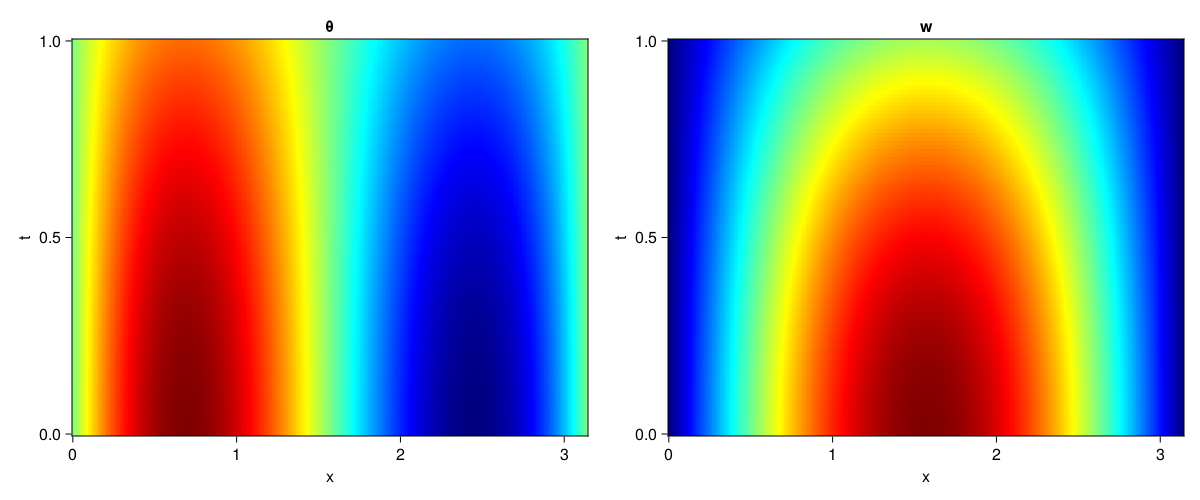

In [44]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo.domain]

θ = [sum(phi.θ(([x,t]), ps.θ)) for x in xs, t in ts]
w = [sum(phi.w(([x,t]), ps.w)) for x in xs, t in ts]

fig = Figure(resolution=(1200,500))
axis = (xlabel="x", ylabel="t", title="θ")
heatmap(fig[1,1], xs, ts, θ, axis=axis, colormap=:jet)
heatmap(fig[1, 2], xs, ts, w, axis= merge(axis, (; title="w")), colormap=:jet)
display(fig)

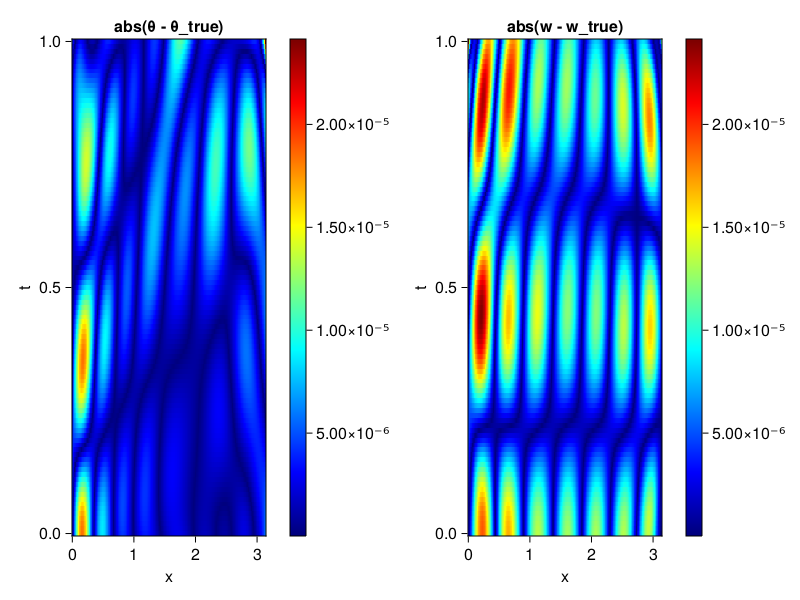

In [45]:
θ_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t)
w_analytic(x,t) = π/2*sin(x)*cos(t)

θ_true = [θ_analytic(x,t) for x in xs, t in ts]
w_true = [w_analytic(x,t) for x in xs, t in ts]

axis = (xlabel="x", ylabel="t", title="abs(θ - θ_true)")
fig, ax1, hm1 = heatmap(xs, ts, abs.(θ .- θ_true), axis=axis, colormap=:jet)
Colorbar(fig[:, 2], hm1)
ax2, hm2= heatmap(fig[1, 3], xs, ts, abs.(w .- w_true), axis= merge(axis, (; title="abs(w - w_true)")), colormap=:jet)
Colorbar(fig[:, 4], hm2)
display(fig)

In [40]:
using JLD2

In [39]:
jldsave("timo_forward.jld2"; pde=timo, pinn=pinn, res=res, prob=prob)